[![Notebook Tutorial](__code/__all/notebook_tutorial.png)](https://neutronimaging.ornl.gov/ct-reconstruction/)

<img src='__docs/notebook_rules.png' />

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import timeit
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display

In [10]:
def checkbox1_changed(value):
    print(value)
def checkbox2_changed(value):
    print(value)
def checkbox3_changed(value):
    print(value)
def checkbox4_changed(value):
    print(value)


In [11]:
line1 = widgets.HBox([widgets.Checkbox(value=True,
                                       description="Direct minimization"),
                      widgets.Label("N/A",
                                   layout=widgets.Layout(width="100px")),
                      widgets.Label("Calculation in progress",
                                   layout=widgets.Layout(width="100px"))
                     ])
checkbox1 = line1.children[0]

line2 = widgets.HBox([widgets.Checkbox(value=False,
                                       description="Phase correlation"),
                      widgets.Label("N/A",
                                   layout=widgets.Layout(width="100px")),
                     ])
checkbox2 = line2.children[0]

line3 = widgets.HBox([widgets.Checkbox(value=False,
                                       description="Use center"),
                      widgets.Label("N/A",
                                   layout=widgets.Layout(width="100px")),
                     ])
checkbox3 = line3.children[0]

line4 = widgets.HBox([widgets.Checkbox(value=False,
                                       description="User defined"),
                      widgets.FloatText(0,
                                        
                                   layout=widgets.Layout(width="100px")),
                     ])
checkbox4 = line4.children[0]

checkbox1.observe(checkbox1_changed, names="value")
checkbox2.observe(checkbox2_changed, names="value")
checkbox3.observe(checkbox3_changed, names="value")
checkbox4.observe(checkbox4_changed, names="value")

vertical_layout = widgets.VBox([line1, line2, line3, line4])
display(vertical_layout)


{'name': 'value', 'old': True, 'new': False, 'owner': Checkbox(value=False, description='Direct minimization'), 'type': 'change'}
{'name': 'value', 'old': False, 'new': True, 'owner': Checkbox(value=True, description='Direct minimization'), 'type': 'change'}
{'name': 'value', 'old': True, 'new': False, 'owner': Checkbox(value=False, description='Direct minimization'), 'type': 'change'}
{'name': 'value', 'old': False, 'new': True, 'owner': Checkbox(value=True, description='Direct minimization'), 'type': 'change'}


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib notebook

import imars3d
print(f"Using imarsd version {imars3d.__version__}")

from __code.imars3dui import Imars3dui
from __code.roi_selection_ui import Interface

from __code import system
system.System.select_working_dir()
from __code.__all import custom_style
custom_style.style()

Using imarsd version 1.1.0.dev253


** Using Debugging Mode! **


In [5]:
%gui qt

# Select input data 

## raw data

In [6]:
o_imars3dui = Imars3dui(working_dir=system.System.get_working_dir())
o_imars3dui.select_raw()

raw folder selected: ['/Users/j35/HFIR/CG1D/IPTS-31148/raw/ct_scans/December3_2022'] with 1288 files)


## ob 

In [7]:
o_imars3dui.select_ob()

ob folder selected: ['/Users/j35/HFIR/CG1D/IPTS-31148/raw/ob/December3_2022'] with 12 files)


## dc 

In [8]:
o_imars3dui.select_dc()

dc folder selected: ['/Users/j35/HFIR/CG1D/IPTS-31148/raw/dc/2022_12_05'] with 10 files)


# Load

ct:   0%|          | 0/1288 [00:00<?, ?it/s]

ob:   0%|          | 0/12 [00:00<?, ?it/s]

dc:   0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


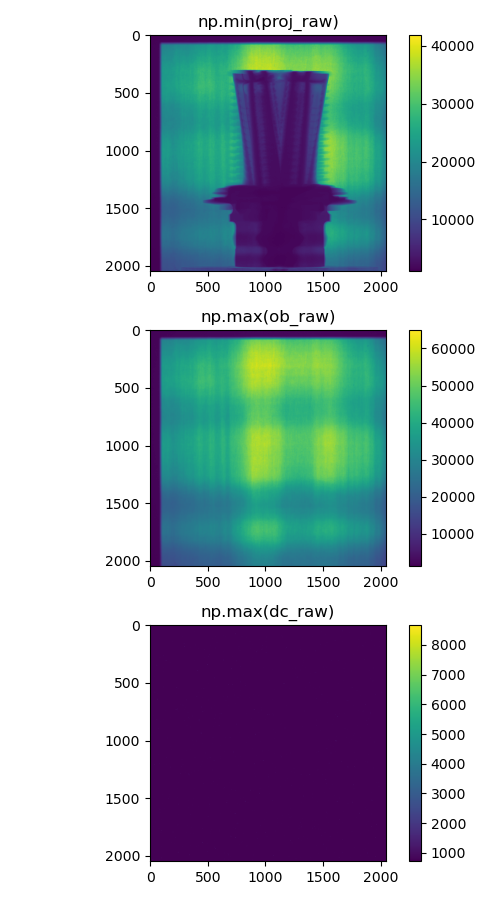

In [9]:
o_imars3dui.load_and_display_data()

# Crop

In [10]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='crop',
                  callback=o_imars3dui.crop_and_display_data)
o_gui.show()

Running crop ...
cropping done!


# Gamma filtering  (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [11]:
o_imars3dui.gamma_filtering()

Running gamma filtering ...
Gamma filtering done in 98.33s


# Normalization (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

Running normalization ...
normalization done in 43.07s


<IPython.core.display.Javascript object>


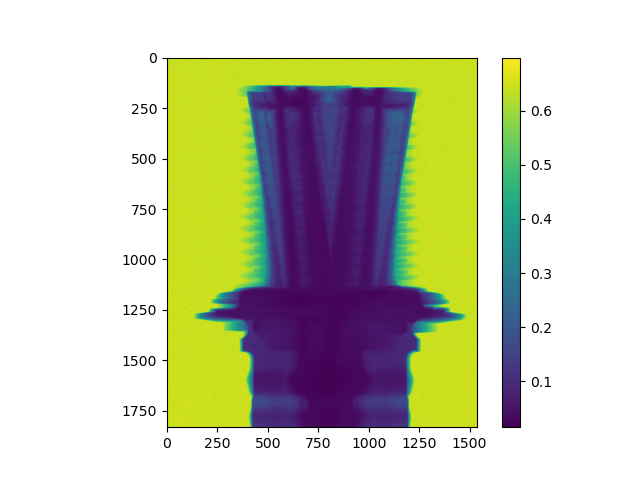

In [12]:
o_imars3dui.normalization_and_display()

# Beam fluctuation correction

Select a region that does not contain the sample to improve the normalization

<IPython.core.display.Javascript object>


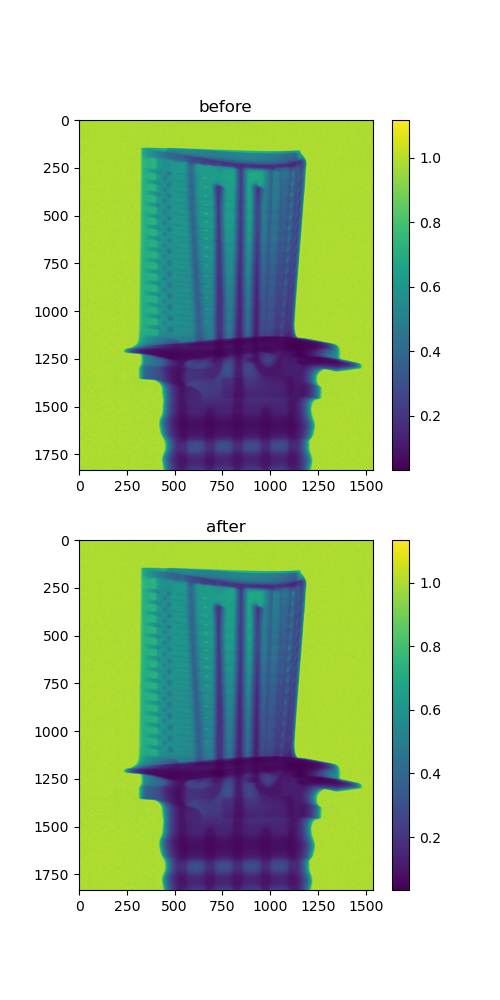

In [13]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='background',
                  callback=o_imars3dui.beam_fluctuation_correction)
o_gui.show()

# Transmission to attenuation

<IPython.core.display.Javascript object>


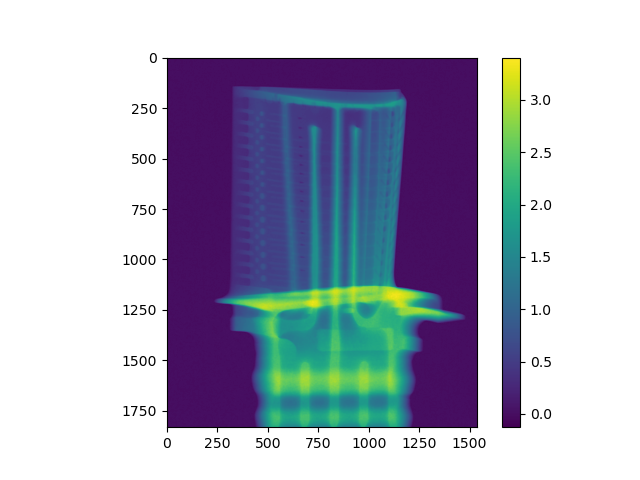

In [14]:
o_imars3dui.minus_log_and_display()

# Tilt correction (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

## find 0 and 180 degrees files

In [15]:
o_imars3dui.find_0_180_degrees_files()

## calculate tilt 

In [16]:
o_imars3dui.calculate_tilt()

Calculating tilt ...


## apply tilt correction

In [ ]:
o_imars3dui.apply_tilt_and_display()

Applying tilt correction ...


Applying tilt corr:   0%|          | 0/1288 [00:00<?, ?it/s]

# Strikes removal (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

### using imars3d - ketcham method working on 3D stack

In [21]:
o_imars3dui.strikes_removal()

Running strikes removal ...


Removing ring artifact:   0%|          | 0/1832 [00:00<?, ?it/s]

 strikes removal done!
time= 128.11s


# Rotation center (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [22]:
o_imars3dui.rotation_center()

Running rotation center ...


Finding rotation center:   0%|          | 0/1291 [00:00<?, ?it/s]

rotation center found in 204.38s
 - value: (806.5,)


# Reconstruction 

Running reconstruction ...
 reconstruction done!
time= 44.39s


<IPython.core.display.Javascript object>


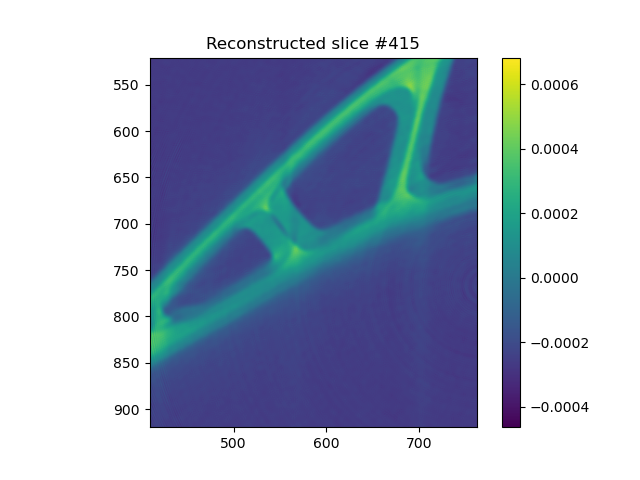

interactive(children=(IntSlider(value=0, description='index', max=1832), Output()), _dom_classes=('widget-inte…

In [23]:
o_imars3dui.reconstruction_and_display()

# Export


In [ ]:
o_imars3dui.export()